# Time Series Forecasting Model - EDA

## Objective
Perform exploratory data analysis for time series forecasting of average daily energy consumption per household.

**Target Variable**: `avg_kwh_per_household_per_day`  
**Features**: Date/time only  
**Model Type**: Simple time series forecasting (ARIMA, Prophet, or LSTM)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

print("Libraries imported successfully")

Libraries imported successfully


## Data Loading and Preparation

Load the daily dataset and create the normalized time series for forecasting.

In [4]:
# Load the daily dataset
df = pd.read_csv('../build/datasets/daily_dataset.csv')

# Convert day to datetime
df['day'] = pd.to_datetime(df['day'])

# Create time series dataset: aggregate by day and normalize by household count
ts_data = df.groupby('day').agg(
    total_energy=('energy_sum', 'sum'),
    num_households=('LCLid', 'nunique')
).reset_index()

# Calculate normalized target variable
ts_data['avg_kwh_per_household_per_day'] = ts_data['total_energy'] / ts_data['num_households']

# Set date as index for time series analysis
ts_data.set_index('day', inplace=True)
ts_data.sort_index(inplace=True)

print(f"Time series data shape: {ts_data.shape}")
print(f"Date range: {ts_data.index.min()} to {ts_data.index.max()}")
print(f"Frequency: {pd.infer_freq(ts_data.index)}")

ts_data.head()

Time series data shape: (829, 3)
Date range: 2011-11-23 00:00:00 to 2014-02-28 00:00:00
Frequency: D


,total_energy,num_households,avg_kwh_per_household_per_day
day,,,
2011-11-23,90.385000,13,6.952692
2011-11-24,213.412000,25,8.536480
2011-11-25,303.993000,32,9.499781
2011-11-26,420.976000,41,10.267707
2011-11-27,444.883001,41,10.850805


## Basic Time Series Statistics

In [5]:
# Extract the target series
y = ts_data['avg_kwh_per_household_per_day']

print("=== Target Variable Statistics ===")
print(f"Mean: {y.mean():.3f} kWh/household/day")
print(f"Std: {y.std():.3f} kWh/household/day")
print(f"Min: {y.min():.3f} kWh/household/day")
print(f"Max: {y.max():.3f} kWh/household/day")
print(f"Coefficient of Variation: {(y.std()/y.mean()):.3f}")

print("\n=== Missing Data Check ===")
print(f"Missing values: {y.isnull().sum()}")
print(f"Data completeness: {(1 - y.isnull().sum()/len(y)):.1%}")

=== Target Variable Statistics ===
Mean: 10.358 kWh/household/day
Std: 1.886 kWh/household/day
Min: 0.209 kWh/household/day
Max: 15.940 kWh/household/day
Coefficient of Variation: 0.182

=== Missing Data Check ===
Missing values: 0
Data completeness: 100.0%


## Time Series Visualization

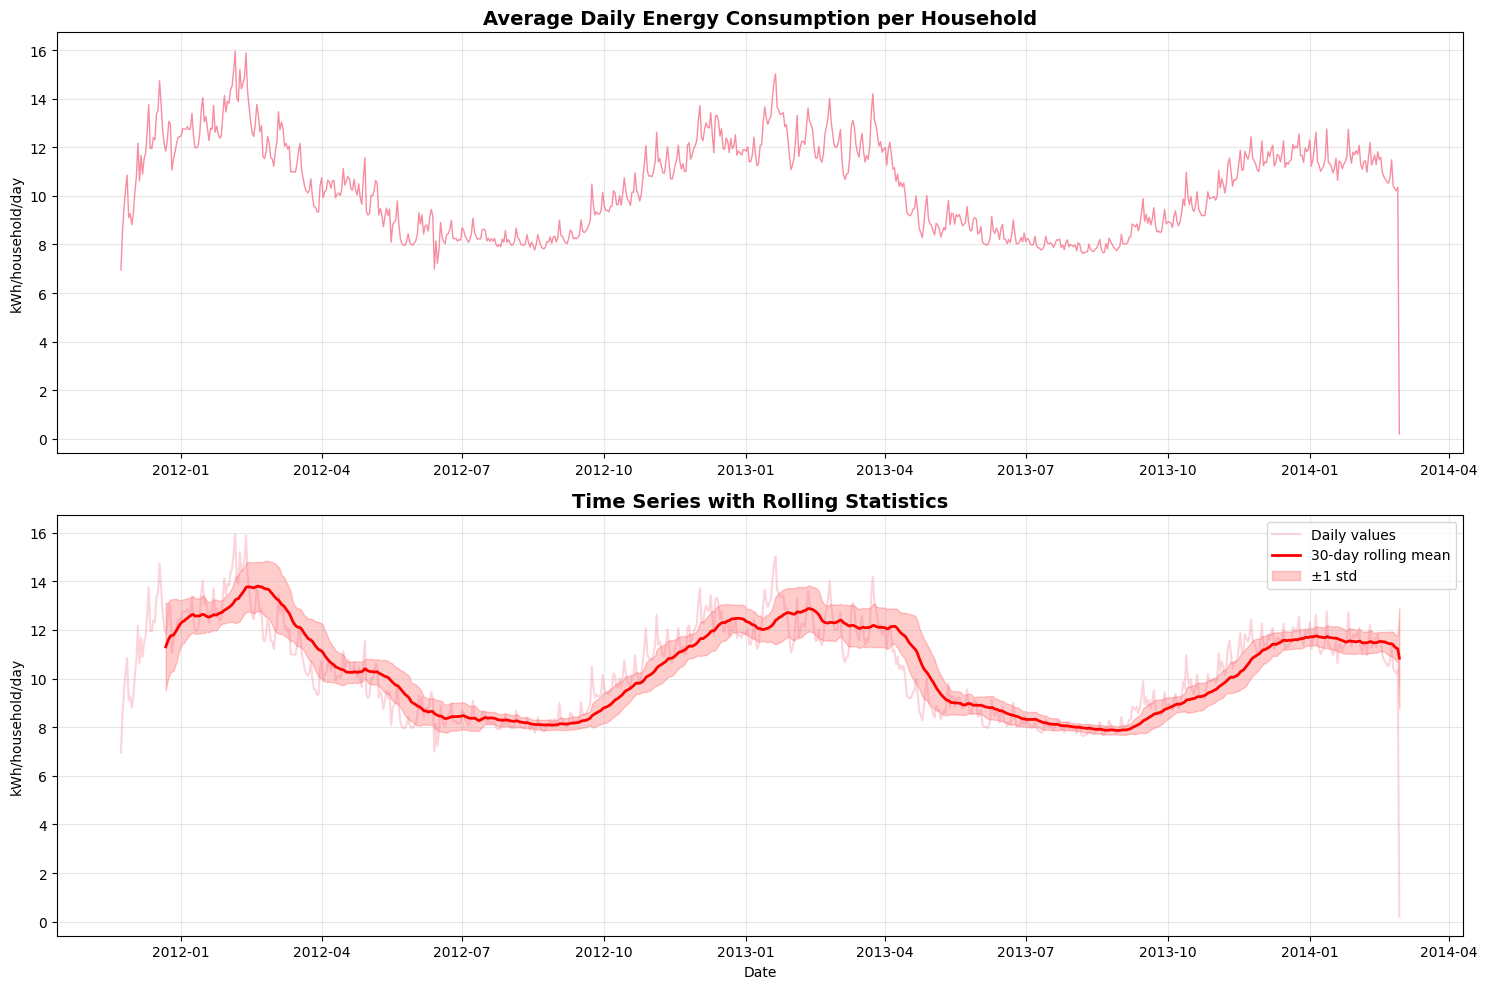

In [6]:
# Plot the raw time series
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Full time series
axes[0].plot(y.index, y.values, linewidth=1, alpha=0.8)
axes[0].set_title('Average Daily Energy Consumption per Household', fontsize=14, fontweight='bold')
axes[0].set_ylabel('kWh/household/day')
axes[0].grid(True, alpha=0.3)

# Rolling statistics
rolling_mean = y.rolling(window=30).mean()
rolling_std = y.rolling(window=30).std()

axes[1].plot(y.index, y.values, alpha=0.3, label='Daily values')
axes[1].plot(rolling_mean.index, rolling_mean.values, color='red', linewidth=2, label='30-day rolling mean')
axes[1].fill_between(rolling_mean.index, 
                     rolling_mean - rolling_std, 
                     rolling_mean + rolling_std, 
                     alpha=0.2, color='red', label='±1 std')
axes[1].set_title('Time Series with Rolling Statistics', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('kWh/household/day')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Time Series Decomposition

Decompose the series into trend, seasonal, and residual components.

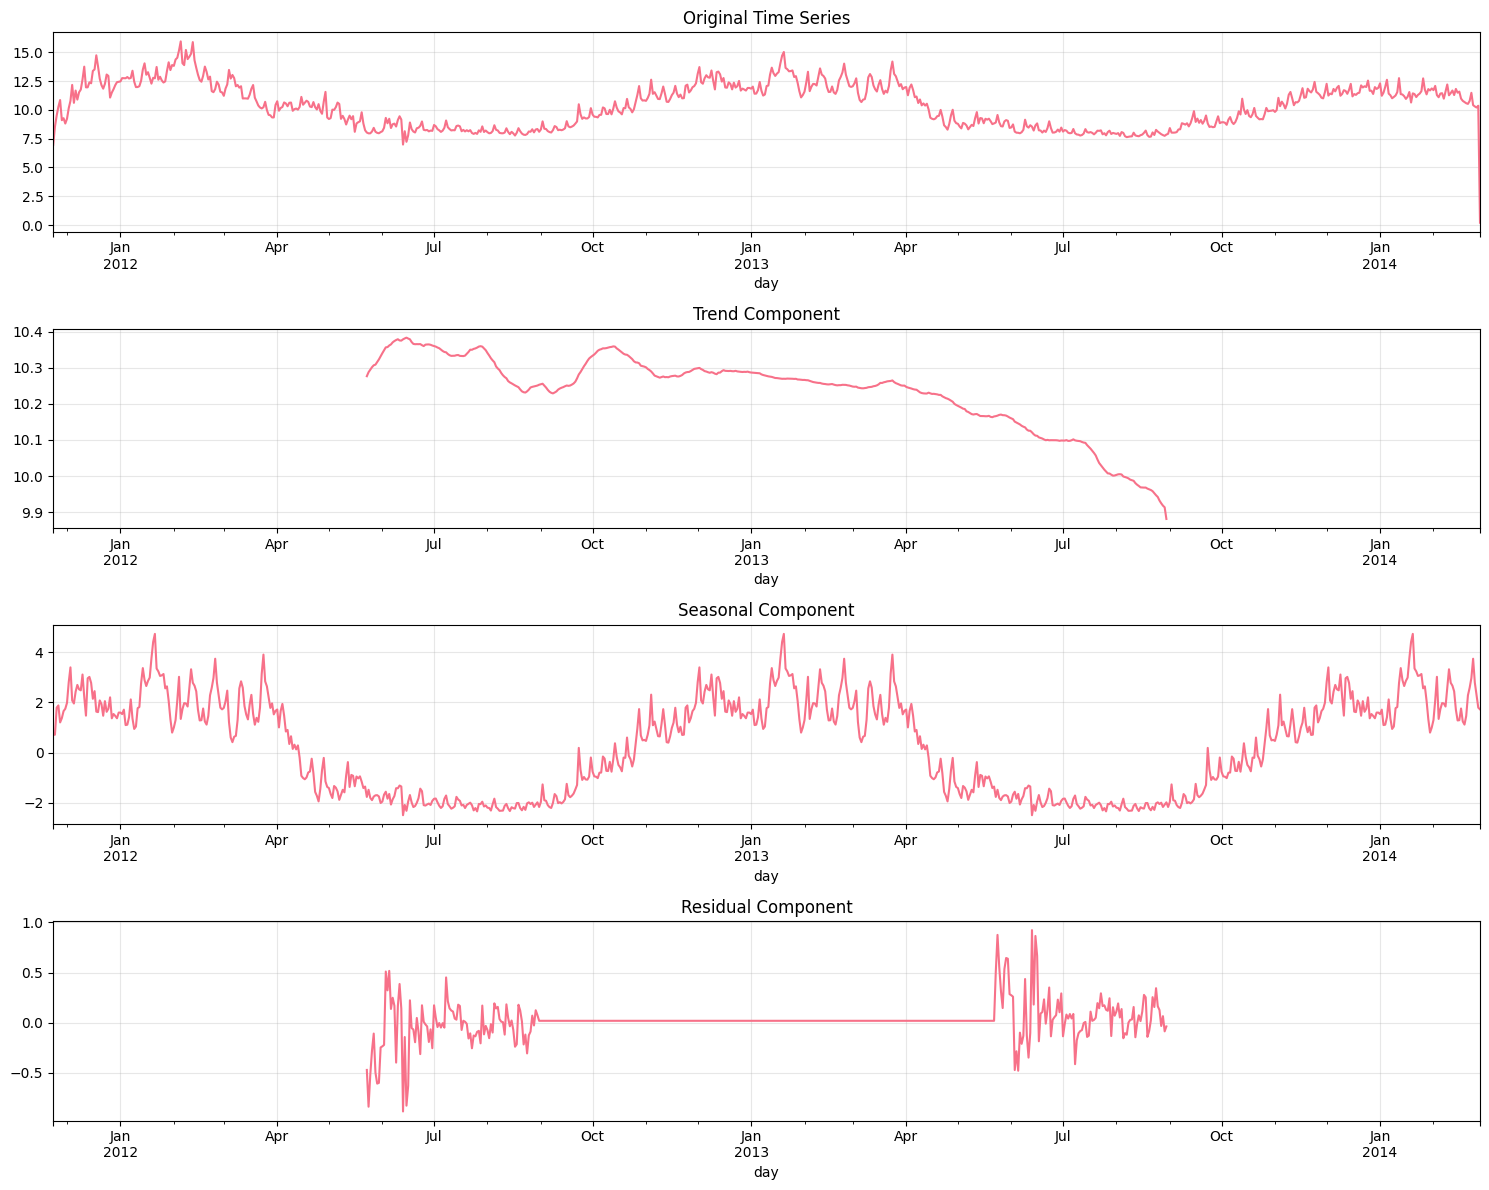

=== Decomposition Analysis ===
Overall trend change: -0.396 kWh/household/day
Seasonal amplitude: 7.235 kWh/household/day
Residual std: 0.176 kWh/household/day


In [7]:
# Perform seasonal decomposition
decomposition = seasonal_decompose(y.dropna(), model='additive', period=365)

# Plot decomposition
fig, axes = plt.subplots(4, 1, figsize=(15, 12))

decomposition.observed.plot(ax=axes[0], title='Original Time Series')
axes[0].grid(True, alpha=0.3)

decomposition.trend.plot(ax=axes[1], title='Trend Component')
axes[1].grid(True, alpha=0.3)

decomposition.seasonal.plot(ax=axes[2], title='Seasonal Component')
axes[2].grid(True, alpha=0.3)

decomposition.resid.plot(ax=axes[3], title='Residual Component')
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print decomposition insights
print("=== Decomposition Analysis ===")
trend_change = (decomposition.trend.dropna().iloc[-1] - decomposition.trend.dropna().iloc[0])
print(f"Overall trend change: {trend_change:.3f} kWh/household/day")
print(f"Seasonal amplitude: {decomposition.seasonal.max() - decomposition.seasonal.min():.3f} kWh/household/day")
print(f"Residual std: {decomposition.resid.std():.3f} kWh/household/day")

## Seasonality Analysis

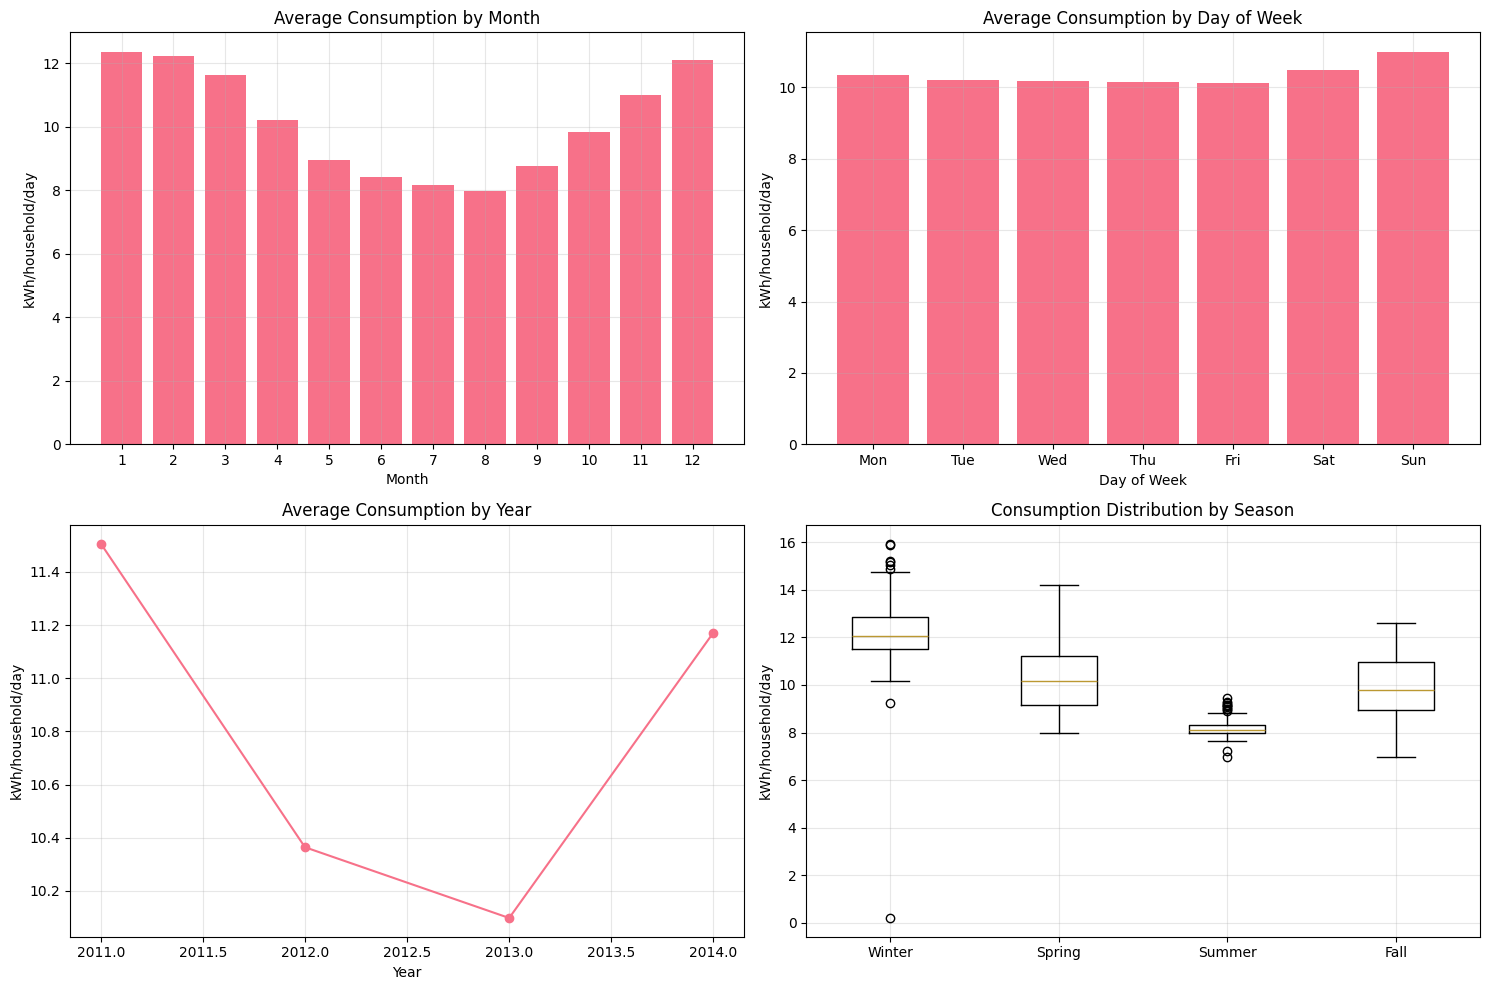

=== Seasonal Patterns ===
Highest consumption month: 1 (12.35 kWh/household/day)
Lowest consumption month: 8 (7.98 kWh/household/day)
Seasonal variation: 4.37 kWh/household/day


In [8]:
# Create seasonal plots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Monthly patterns
monthly_avg = y.groupby(y.index.month).mean()
axes[0,0].bar(range(1, 13), monthly_avg.values)
axes[0,0].set_title('Average Consumption by Month')
axes[0,0].set_xlabel('Month')
axes[0,0].set_ylabel('kWh/household/day')
axes[0,0].set_xticks(range(1, 13))
axes[0,0].grid(True, alpha=0.3)

# Day of week patterns
dow_avg = y.groupby(y.index.dayofweek).mean()
dow_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
axes[0,1].bar(range(7), dow_avg.values)
axes[0,1].set_title('Average Consumption by Day of Week')
axes[0,1].set_xlabel('Day of Week')
axes[0,1].set_ylabel('kWh/household/day')
axes[0,1].set_xticks(range(7))
axes[0,1].set_xticklabels(dow_names)
axes[0,1].grid(True, alpha=0.3)

# Yearly patterns
yearly_avg = y.groupby(y.index.year).mean()
axes[1,0].plot(yearly_avg.index, yearly_avg.values, marker='o')
axes[1,0].set_title('Average Consumption by Year')
axes[1,0].set_xlabel('Year')
axes[1,0].set_ylabel('kWh/household/day')
axes[1,0].grid(True, alpha=0.3)

# Seasonal boxplot
seasons = y.index.month%12 // 3 + 1
season_names = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
seasonal_data = [y[seasons == i].values for i in range(1, 5)]
axes[1,1].boxplot(seasonal_data, labels=list(season_names.values()))
axes[1,1].set_title('Consumption Distribution by Season')
axes[1,1].set_ylabel('kWh/household/day')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print seasonal insights
print("=== Seasonal Patterns ===")
print(f"Highest consumption month: {monthly_avg.idxmax()} ({monthly_avg.max():.2f} kWh/household/day)")
print(f"Lowest consumption month: {monthly_avg.idxmin()} ({monthly_avg.min():.2f} kWh/household/day)")
print(f"Seasonal variation: {monthly_avg.max() - monthly_avg.min():.2f} kWh/household/day")

## Stationarity Analysis

Test whether the time series is stationary (constant mean and variance over time).

=== Original Series Stationarity Test ===
ADF Statistic: -1.751533
p-value: 0.404776
Critical Values:
	1%: -3.438
	5%: -2.865
	10%: -2.569
Result: Series is non-stationary (fail to reject null hypothesis)

=== First Difference Stationarity Test ===
ADF Statistic: -4.418031
p-value: 0.000276
Critical Values:
	1%: -3.438
	5%: -2.865
	10%: -2.569
Result: Series is stationary (reject null hypothesis)



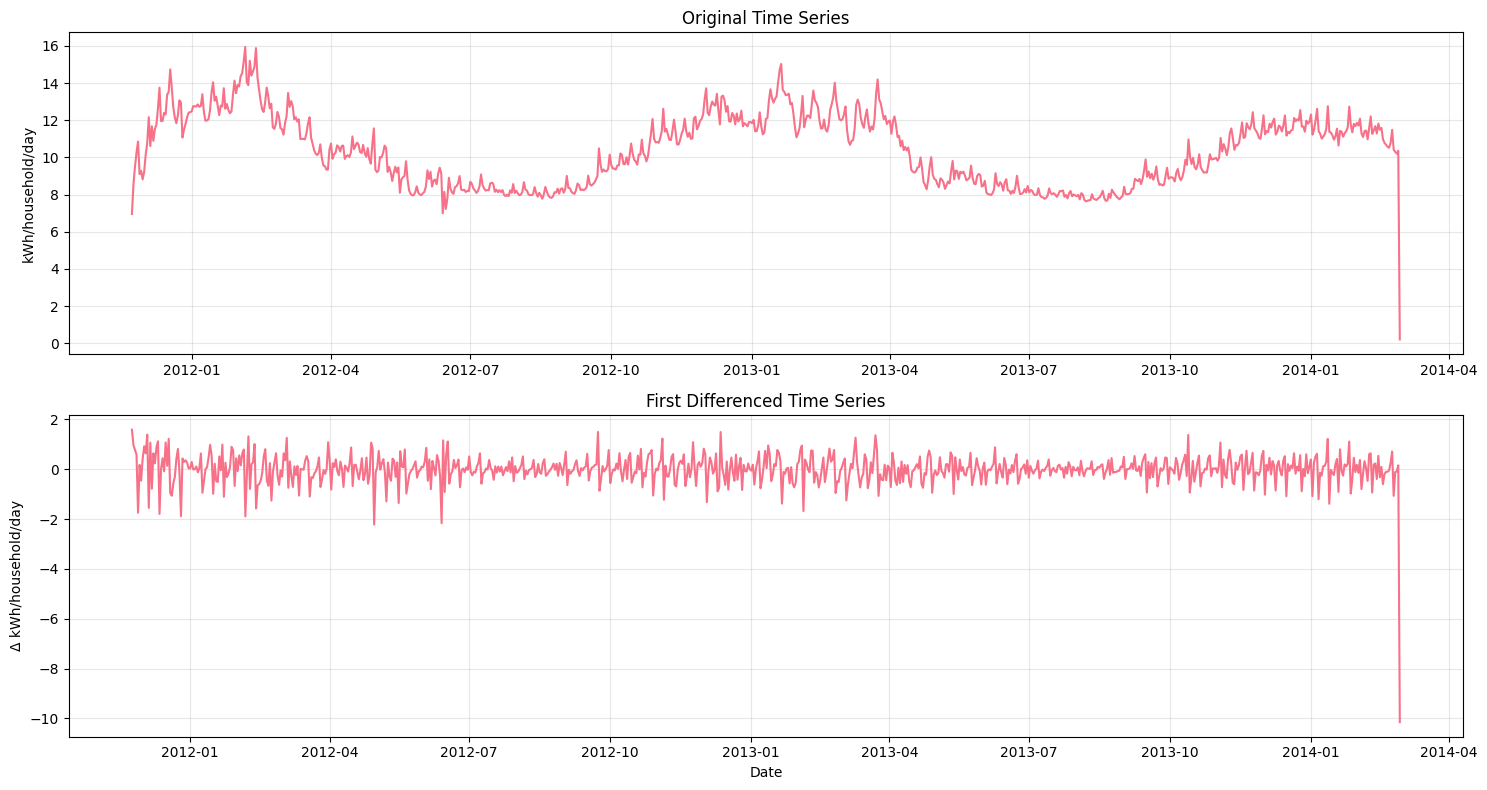

In [9]:
def check_stationarity(timeseries, title):
    """Perform Augmented Dickey-Fuller test for stationarity"""
    print(f"=== {title} ===")
    
    # Perform ADF test
    result = adfuller(timeseries.dropna())
    
    print(f'ADF Statistic: {result[0]:.6f}')
    print(f'p-value: {result[1]:.6f}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.3f}')
    
    if result[1] <= 0.05:
        print("Result: Series is stationary (reject null hypothesis)")
    else:
        print("Result: Series is non-stationary (fail to reject null hypothesis)")
    print()

# Test original series
check_stationarity(y, "Original Series Stationarity Test")

# Test first difference
y_diff = y.diff().dropna()
check_stationarity(y_diff, "First Difference Stationarity Test")

# Plot original vs differenced series
fig, axes = plt.subplots(2, 1, figsize=(15, 8))

axes[0].plot(y.index, y.values)
axes[0].set_title('Original Time Series')
axes[0].set_ylabel('kWh/household/day')
axes[0].grid(True, alpha=0.3)

axes[1].plot(y_diff.index, y_diff.values)
axes[1].set_title('First Differenced Time Series')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Δ kWh/household/day')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Autocorrelation Analysis

Analyze the autocorrelation structure to inform ARIMA model parameters.

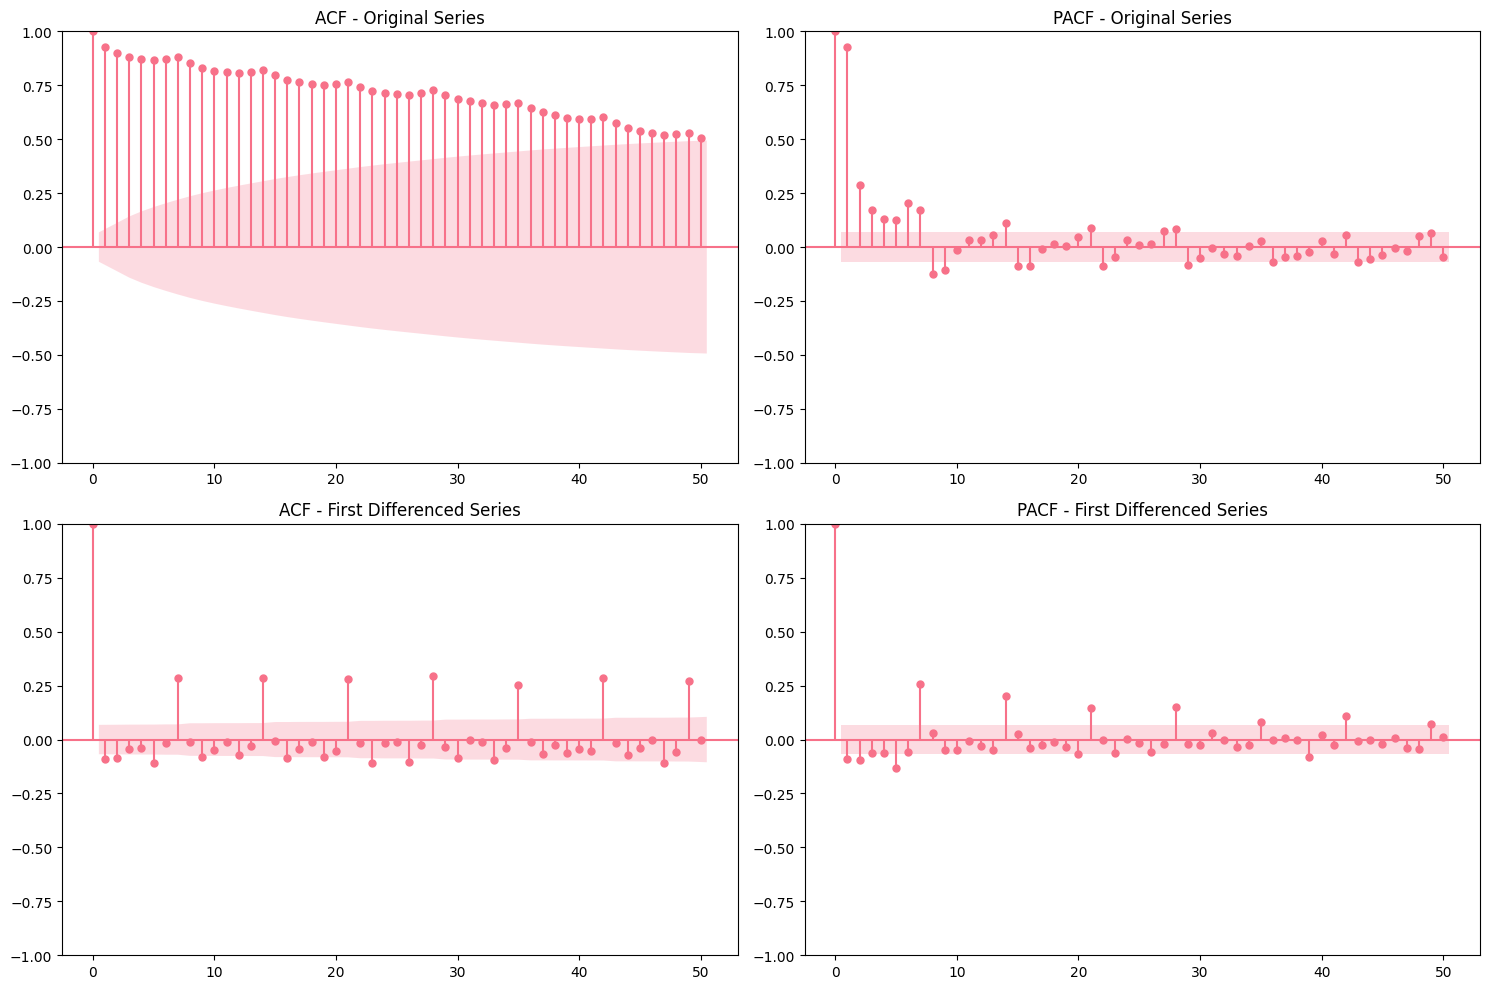

=== Autocorrelation Analysis ===
Significant ACF lags (>0.1):
  Lag 1: 0.926
  Lag 2: 0.899
  Lag 3: 0.882
  Lag 4: 0.870
  Lag 5: 0.865
  Lag 6: 0.873
  Lag 7: 0.880
  Lag 8: 0.855
  Lag 9: 0.831
  Lag 10: 0.818
  Lag 11: 0.811
  Lag 12: 0.807
  Lag 13: 0.812
  Lag 14: 0.821
  Lag 15: 0.798
  Lag 16: 0.775
  Lag 17: 0.763
  Lag 18: 0.756
  Lag 19: 0.752
  Lag 20: 0.757

Significant PACF lags (>0.1):
  Lag 1: 0.927
  Lag 2: 0.295
  Lag 3: 0.175
  Lag 4: 0.137
  Lag 5: 0.133
  Lag 6: 0.213
  Lag 7: 0.186
  Lag 8: -0.118
  Lag 9: -0.109
  Lag 14: 0.120


In [10]:
# Plot ACF and PACF for original series
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Original series
plot_acf(y.dropna(), ax=axes[0,0], lags=50, title='ACF - Original Series')
plot_pacf(y.dropna(), ax=axes[0,1], lags=50, title='PACF - Original Series')

# First differenced series
plot_acf(y_diff, ax=axes[1,0], lags=50, title='ACF - First Differenced Series')
plot_pacf(y_diff, ax=axes[1,1], lags=50, title='PACF - First Differenced Series')

plt.tight_layout()
plt.show()

# Calculate key autocorrelations
from statsmodels.tsa.stattools import acf, pacf

acf_values = acf(y.dropna(), nlags=20)
pacf_values = pacf(y.dropna(), nlags=20)

print("=== Autocorrelation Analysis ===")
print("Significant ACF lags (>0.1):")
for i, val in enumerate(acf_values[1:], 1):
    if abs(val) > 0.1:
        print(f"  Lag {i}: {val:.3f}")

print("\nSignificant PACF lags (>0.1):")
for i, val in enumerate(pacf_values[1:], 1):
    if abs(val) > 0.1:
        print(f"  Lag {i}: {val:.3f}")

## Distribution Analysis

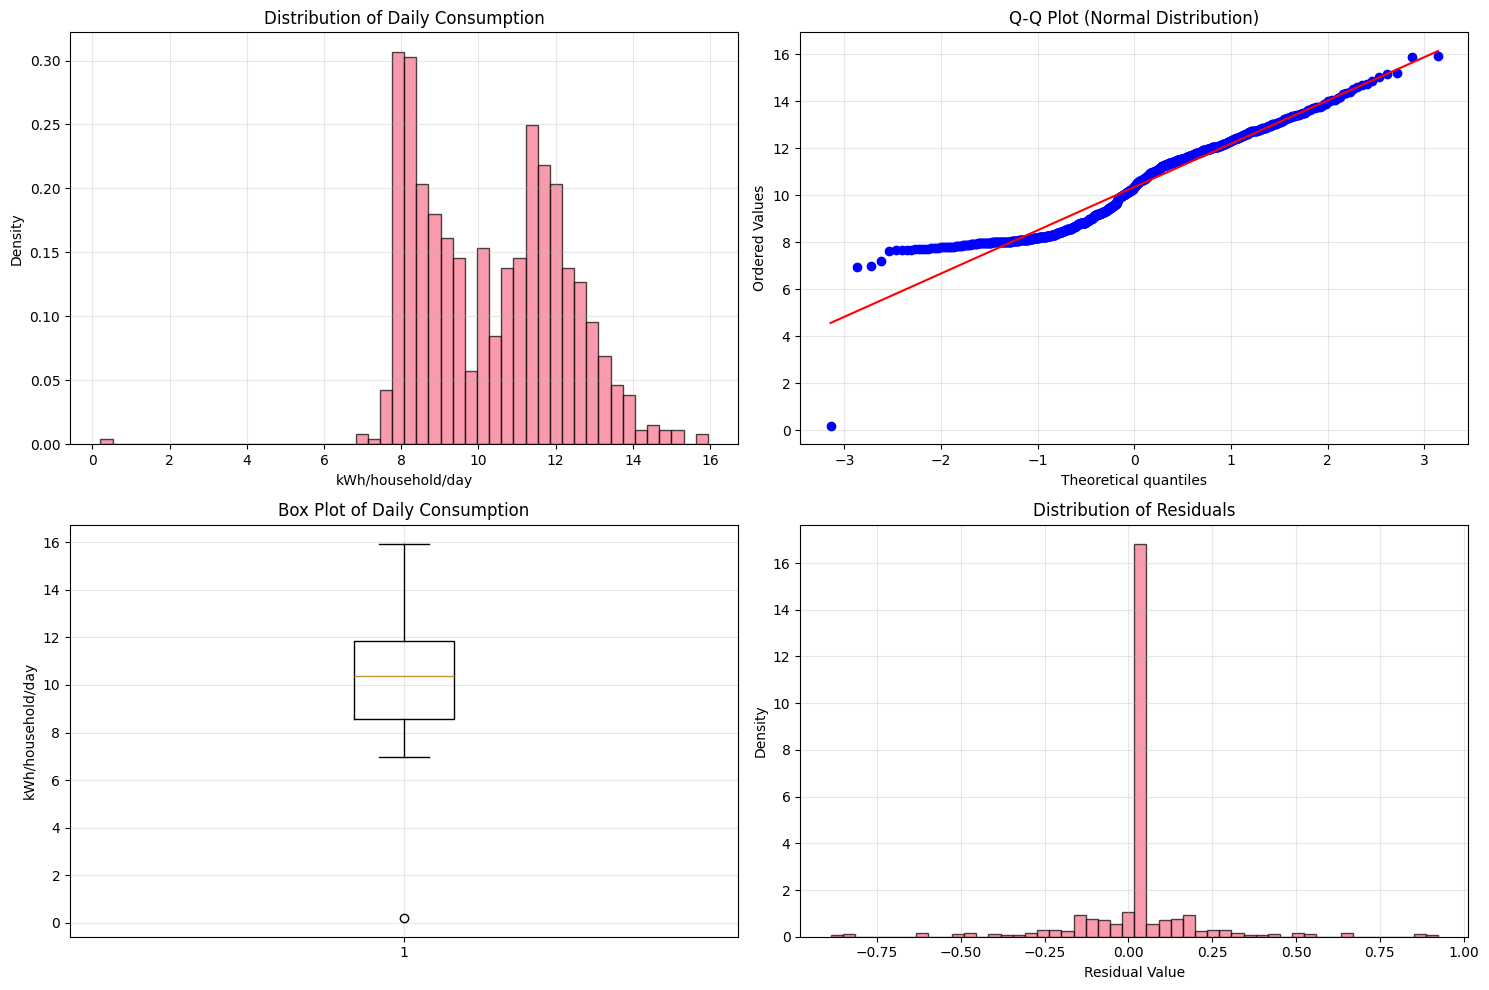

=== Distribution Analysis ===
Skewness: 0.078
Kurtosis: -0.061

Jarque-Bera test: statistic=0.959, p-value=0.619149
Shapiro-Wilk test: statistic=0.948, p-value=0.000000

Outliers detected: 1 (0.1% of data)
Outlier range: 0.21 to 0.21 kWh/household/day


In [11]:
# Distribution analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Histogram
axes[0,0].hist(y.dropna(), bins=50, density=True, alpha=0.7, edgecolor='black')
axes[0,0].set_title('Distribution of Daily Consumption')
axes[0,0].set_xlabel('kWh/household/day')
axes[0,0].set_ylabel('Density')
axes[0,0].grid(True, alpha=0.3)

# Q-Q plot
stats.probplot(y.dropna(), dist="norm", plot=axes[0,1])
axes[0,1].set_title('Q-Q Plot (Normal Distribution)')
axes[0,1].grid(True, alpha=0.3)

# Box plot
axes[1,0].boxplot(y.dropna())
axes[1,0].set_title('Box Plot of Daily Consumption')
axes[1,0].set_ylabel('kWh/household/day')
axes[1,0].grid(True, alpha=0.3)

# Residuals from trend
if 'decomposition' in locals():
    axes[1,1].hist(decomposition.resid.dropna(), bins=50, density=True, alpha=0.7, edgecolor='black')
    axes[1,1].set_title('Distribution of Residuals')
    axes[1,1].set_xlabel('Residual Value')
    axes[1,1].set_ylabel('Density')
    axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistical tests
from scipy.stats import jarque_bera, shapiro

print("=== Distribution Analysis ===")
print(f"Skewness: {stats.skew(y.dropna()):.3f}")
print(f"Kurtosis: {stats.kurtosis(y.dropna()):.3f}")

# Normality tests
jb_stat, jb_p = jarque_bera(y.dropna())
print(f"\nJarque-Bera test: statistic={jb_stat:.3f}, p-value={jb_p:.6f}")

if len(y.dropna()) <= 5000:  # Shapiro-Wilk has sample size limit
    sw_stat, sw_p = shapiro(y.dropna())
    print(f"Shapiro-Wilk test: statistic={sw_stat:.3f}, p-value={sw_p:.6f}")

# Outlier detection
Q1 = y.quantile(0.25)
Q3 = y.quantile(0.75)
IQR = Q3 - Q1
outliers = y[(y < Q1 - 1.5*IQR) | (y > Q3 + 1.5*IQR)]
print(f"\nOutliers detected: {len(outliers)} ({len(outliers)/len(y):.1%} of data)")
if len(outliers) > 0:
    print(f"Outlier range: {outliers.min():.2f} to {outliers.max():.2f} kWh/household/day")

## Model Selection Recommendations

Based on the EDA findings, provide recommendations for time series forecasting models.

In [12]:
print("=== TIME SERIES FORECASTING MODEL RECOMMENDATIONS ===")
print()

# Analyze findings
has_trend = abs(trend_change) > 0.1
has_seasonality = (decomposition.seasonal.max() - decomposition.seasonal.min()) > 0.5
is_stationary = adfuller(y.dropna())[1] <= 0.05
strong_autocorr = any(abs(val) > 0.3 for val in acf_values[1:8])

print(f"Data Characteristics:")
print(f"  • Trend present: {'Yes' if has_trend else 'No'}")
print(f"  • Seasonality present: {'Yes' if has_seasonality else 'No'}")
print(f"  • Series is stationary: {'Yes' if is_stationary else 'No'}")
print(f"  • Strong autocorrelation: {'Yes' if strong_autocorr else 'No'}")
print(f"  • Data points: {len(y)}")
print()

print("Recommended Models:")
print()

# ARIMA recommendations
if not is_stationary:
    d_param = 1
else:
    d_param = 0

# Suggest p and q based on PACF and ACF
significant_pacf = sum(1 for val in pacf_values[1:6] if abs(val) > 0.1)
significant_acf = sum(1 for val in acf_values[1:6] if abs(val) > 0.1)

print(f"1. ARIMA Model:")
print(f"   • Suggested parameters: ARIMA({min(significant_pacf, 3)}, {d_param}, {min(significant_acf, 3)})")
if has_seasonality:
    print(f"   • Consider SARIMA with seasonal period = 365 (daily data)")
print(f"   • Pros: Classical approach, interpretable parameters")
print(f"   • Cons: Assumes linear relationships")
print()

# Prophet recommendations
print(f"2. Facebook Prophet:")
print(f"   • Good fit for daily data with strong seasonality")
print(f"   • Handles missing data and outliers well")
print(f"   • Pros: Robust, handles holidays, intuitive")
print(f"   • Cons: Less control over model components")
print()

# LSTM recommendations
print(f"3. LSTM Neural Network:")
print(f"   • Suitable for complex non-linear patterns")
print(f"   • Can capture long-term dependencies")
print(f"   • Pros: Flexible, can model complex relationships")
print(f"   • Cons: Requires more data, less interpretable")
print()

print("Next Steps:")
print("1. Split data into train/validation/test sets")
print("2. Implement and compare the recommended models")
print("3. Use cross-validation for parameter tuning")
print("4. Evaluate using MAE, RMSE, and MAPE metrics")
print("5. Consider ensemble methods combining multiple approaches")

=== TIME SERIES FORECASTING MODEL RECOMMENDATIONS ===

Data Characteristics:
  • Trend present: Yes
  • Seasonality present: Yes
  • Series is stationary: No
  • Strong autocorrelation: Yes
  • Data points: 829

Recommended Models:

1. ARIMA Model:
   • Suggested parameters: ARIMA(3, 1, 3)
   • Consider SARIMA with seasonal period = 365 (daily data)
   • Pros: Classical approach, interpretable parameters
   • Cons: Assumes linear relationships

2. Facebook Prophet:
   • Good fit for daily data with strong seasonality
   • Handles missing data and outliers well
   • Pros: Robust, handles holidays, intuitive
   • Cons: Less control over model components

3. LSTM Neural Network:
   • Suitable for complex non-linear patterns
   • Can capture long-term dependencies
   • Pros: Flexible, can model complex relationships
   • Cons: Requires more data, less interpretable

Next Steps:
1. Split data into train/validation/test sets
2. Implement and compare the recommended models
3. Use cross-valida

## Data Export for Modeling

Export the prepared time series data for model training.

In [14]:
# Prepare final dataset for modeling
model_data = ts_data[['avg_kwh_per_household_per_day']].copy()
model_data = model_data.dropna()

# Add useful features for modeling
model_data['year'] = model_data.index.year
model_data['month'] = model_data.index.month
model_data['day_of_year'] = model_data.index.dayofyear
model_data['day_of_week'] = model_data.index.dayofweek
model_data['is_weekend'] = (model_data.index.dayofweek >= 5).astype(int)

# Export to CSV
model_data.to_csv('../build/datasets/timeseries_model_data.csv')

print(f"Time series modeling dataset exported:")
print(f"  • Shape: {model_data.shape}")
print(f"  • Date range: {model_data.index.min()} to {model_data.index.max()}")
print(f"  • File: ../Data/timeseries_model_data.csv")

model_data.head()

Time series modeling dataset exported:
  • Shape: (829, 6)
  • Date range: 2011-11-23 00:00:00 to 2014-02-28 00:00:00
  • File: ../Data/timeseries_model_data.csv


,avg_kwh_per_household_per_day,year,month,day_of_year,day_of_week,is_weekend
day,,,,,,
2011-11-23,6.952692,2011,11,327,2,0
2011-11-24,8.536480,2011,11,328,3,0
2011-11-25,9.499781,2011,11,329,4,0
2011-11-26,10.267707,2011,11,330,5,1
2011-11-27,10.850805,2011,11,331,6,1
